<h1>Case study: Game Of Thrones</h1>

In this notebook we use the tools of network analysis to answer two questions about the famous TV series <b>Game of Thrones</b>.
The questions are:
<ol>
    <li> which characters form <b>coherent communities</b> within the network</li>
    <li> what are the characters who play an <b>important role</b> in the network and in the series</li>
</ol>
We will work on a network where nodes represent the characters and edges represent the interactions. These edges are weighted by the total number of interactions between the two characters.
<br><br>
The datasets are located <a href="https://github.com/mathbeveridge/gameofthrones">here</a>.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm

import networkx as nx
from nxviz import CircosPlot
import community 

%matplotlib inline

<p>Let's start by defining some functions that we will need for the analysis of this case study.</p>

In [3]:
def draw_standard_graph(G, title, seed=4, k=5):
    
    plt.figure(figsize=(15,15))

    pos= nx.spring_layout(G,k=k, weight='weight', seed=seed)

    betweenness_centrality = nx.betweenness_centrality(G, normalized=True, weight='weight')
    pagerank = nx.pagerank(G)
    max_weighted_degree = max([G.degree(v,weight='weight') for v in G])

    node_color = [pagerank[v] for v in G]
    node_size = [ 1000 + (G.degree(v,weight='weight')/max_weighted_degree) * 10000  for v in G]
    edge_width = [0.01 * G[u][v]['weight'] for u,v in G.edges()]

    nx.draw_networkx(G, pos, node_size=node_size, node_color=node_color,
                          alpha=0.8, with_labels=False, 
                             width=edge_width, edge_color='.4', cmap=plt.cm.YlOrBr)

    greater_than_100 = [x for x in G.edges(data=True) if x[2]['weight']>=100]
    nx.draw_networkx_edges(G, pos, edgelist=greater_than_100, edge_color='#584A0F', alpha=0.6, width=10)

    between_70_100 = [x for x in G.edges(data=True) if (x[2]['weight']>= 70) and (x[2]['weight']<100)]
    nx.draw_networkx_edges(G, pos, edgelist=between_70_100, edge_color='#E7C827', alpha=0.4, width=4)
    
    between_50_70 = [x for x in G.edges(data=True) if (x[2]['weight']>= 50) and (x[2]['weight']<70)]
    nx.draw_networkx_edges(G, pos, edgelist=between_50_70, edge_color='#E7C827', alpha=0.4, width=2)

    top10bet = dict(pd.Series(nx.betweenness_centrality(G)).sort_values(ascending=False)[:10])
    labels = {k:k for k in top10bet.keys()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=14, font_color='#C38D5F', font_weight=900)
    others = {n:n for n in G if n not in top10bet}
    nx.draw_networkx_labels(G, pos, labels=others, font_size=10, font_color='#C38D5F')

    plt.axis('off')
    plt.tight_layout()
    
    fontdict = {'fontsize': 20, 'fontweight' : 400}
    
    plt.title(title, fontdict=fontdict)
    plt.savefig('images/'+title, dpi=400)
    plt.show()
    
def draw_circos(G):
    partition = community.best_partition(G)
    for n in G.nodes():
        G.nodes[n]['group'] =  partition[n]
    
    max_w = max(nx.get_edge_attributes(G, 'weight').values())
    normalized_w = {(v1,v2): 1 + (w['weight']/max_w) * 20 for v1,v2,w in G.edges(data=True)}
    nx.set_edge_attributes(G,normalized_w,'normalized_weight')

    c = CircosPlot(G, node_color='group', node_grouping='group', node_labels=True,
               figsize=(22,22), node_label_layout='rotation', fontsize=10, edge_width="normalized_weight")
    c.draw()

def load_file(filename):
    file = pd.read_csv(filename)
    G = nx.Graph()
    for row in file.iterrows():
        G.add_edge(row[1]['Source'], row[1]['Target'], weight=row[1]['Weight'])
    return G

def draw_bar(measure, title):
    
    #max_measure = max(list(measure.values()))
    #normalized_measure = {k: v/max_measure for k,v in measure.items()}
    
    data = pd.Series(measure).sort_values(ascending=False)[:10]
    data = data.sort_values(ascending=True)
    color = ['#fee391','#fee391','#fee391','#fee391','#fee391','#fee391','#fee391','#fee391','#B9540C','#67331E']
    ax = data.plot(kind='barh', zorder=2, width=0.85, fontsize=8, color=color)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Set x-axis label
    ax.set_xlabel(title, labelpad=10, fontsize=10, weight='bold')

    
def draw_centrality(G):
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 2, 1)
    weighted_degree = { n: G.degree(n, weight=True)  for n in G.nodes()}
    draw_bar(weighted_degree, 'Weighted degree: #interactions that a character has')

    plt.subplot(2, 2, 2)
    draw_bar(nx.eigenvector_centrality(G), 'Eigenvector: #important people a character knows')

    plt.subplot(2, 2, 3)
    draw_bar(nx.pagerank(G), 'Pagerank: #important interactions that a character has')

    plt.subplot(2, 2, 4)
    draw_bar(nx.betweenness_centrality(G,weight=True), 'Betweenness: a character helps connect the network')

    plt.show()

<h1>First season</h1>

In [4]:
firstSeasonGraph = load_file('data/got/got-s1-edges.csv')
print(nx.info(firstSeasonGraph))

Name: 
Type: Graph
Number of nodes: 127
Number of edges: 549
Average degree:   8.6457


Once the dataset is loaded, we can answer the first question using Louvain's algorithm for community detection to find communities and then display them with a circos plot.

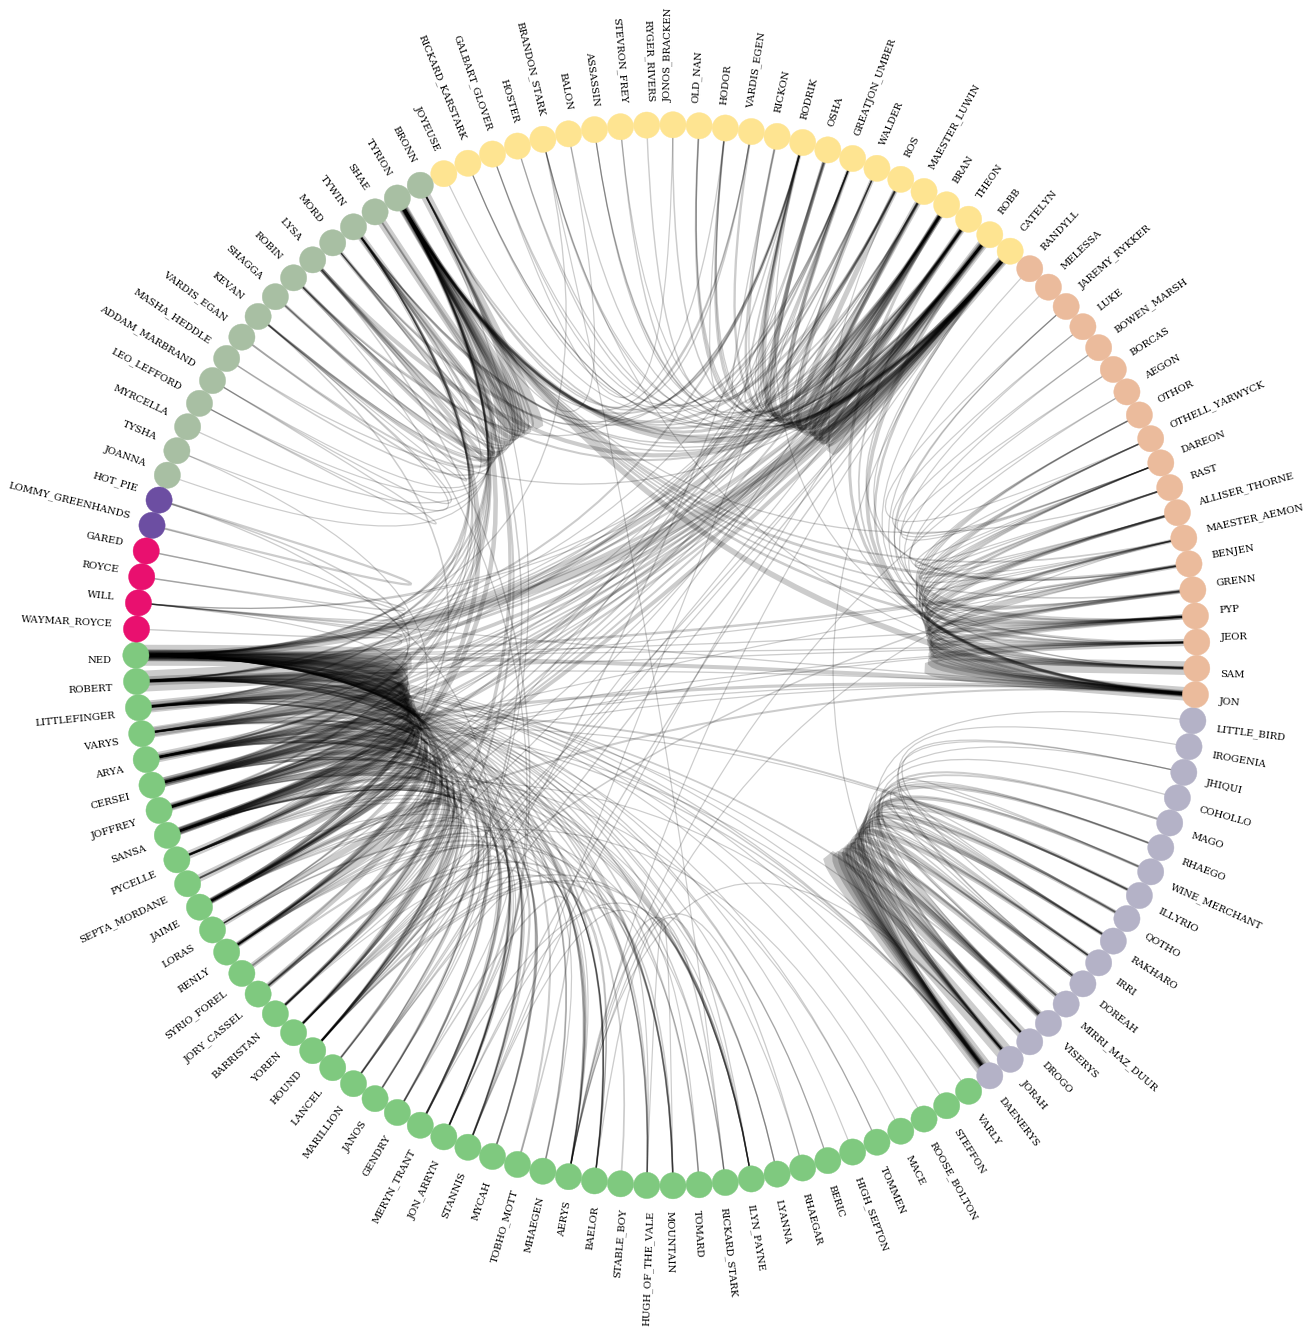

In [4]:
draw_circos(firstSeasonGraph)

Using the Louvain community detection algorithm, 5 main and 2 minor communities are identified (according to the events of the first season). Clockwise from the top the identified communities are:
<ol>
    <li><b>the Starks:</b> Catelyn, Robb, Bran, Hodor</li>
    <li><b>the Night's Watch:</b> Jon Snow, Sam, Pyp</li>
    <li><b>the Dothraki:</b> Daenerys, Drogo, Jorah</li>
    <li><b>King's Landing:</b> Ned, Robert, Cersey, Varys</li>
    <li><b>Night's Watchmen from the prologue:</b> Gared, Royce, Will</li>
    <li><b>the pair of orphans:</b> Lommy, Hot Pie</li>
    <li><b>the Lannisters:</b> Tyrion, Tywin, Shae, Bronn</li>
</ol>
Another piece of information that can be derived from the Circos plot is that most of the scenes are located in <b>King's Landing</b>.

The information shown in the following graph are:
<ul>
    <li><b>pagerank of the node:</b> the color of the node</li>
    <li><b>weighted degree centrality of the node:</b> the size of the node</li>
    <li><b>betweenness centrality of the node:</b> bolder labels indicate the 10 characters with the highest betweenness centrality</li>
    <li><b>number of interactions between two characters:</b> the thickness of the edge that connects them</li>
</ul>

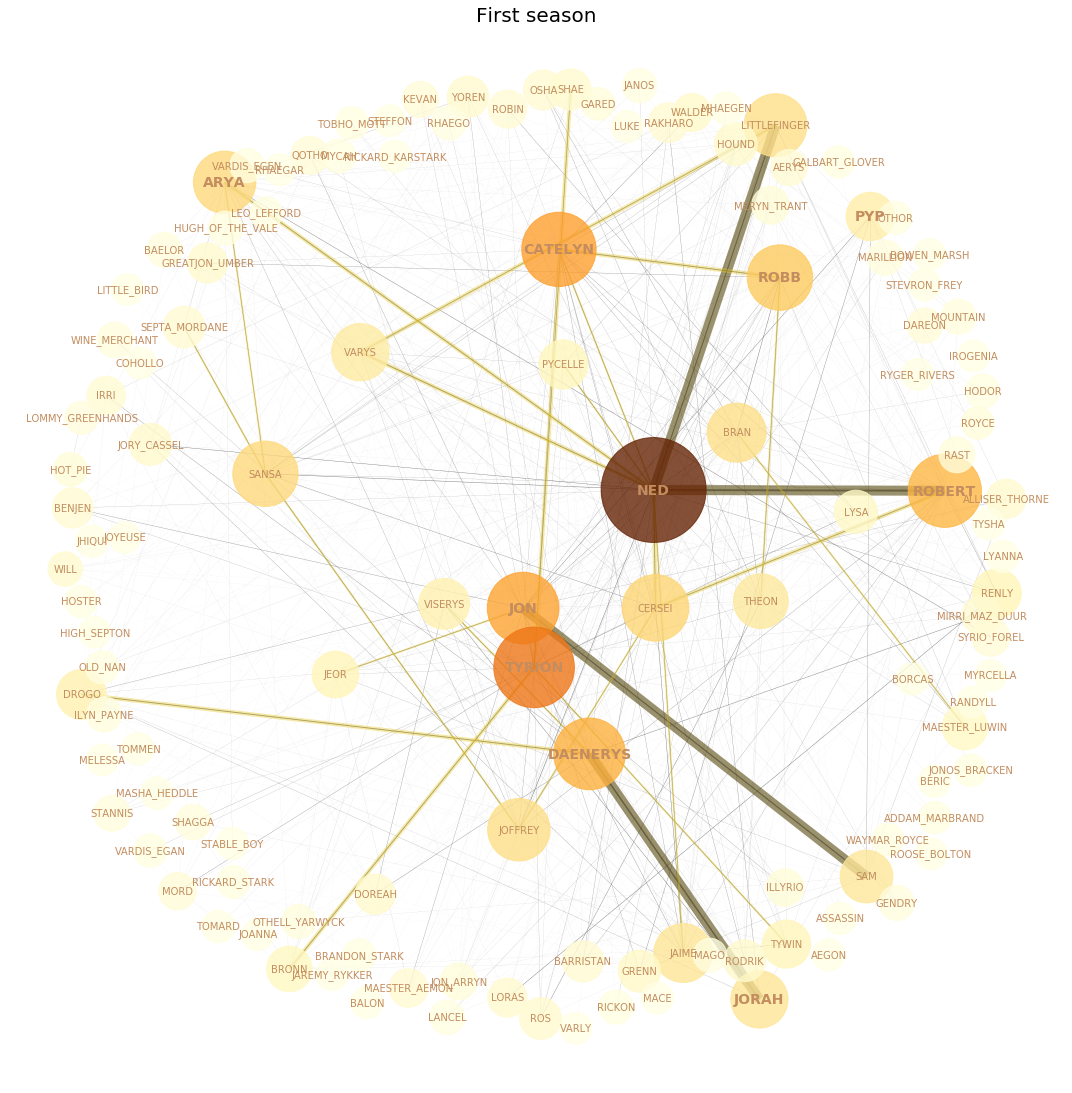

In [5]:
draw_standard_graph(firstSeasonGraph, "First season")

From the visualization of the network you can recognize some important triads:
<ul>
    <li>Ned, Littlefinger, Varys</li>
    <li>Ned, Robert, Cersei</li>
    <li>Ned, Arya, Sansa</li>
</ul>
and others less important:
<ul>
    <li>Daenerys, Drogo, Viserys</li>
    <li>Jon, Sam, Pyp</li>
</ul>
Finding strong triads and dyads is important because they capture distinct plotlines.

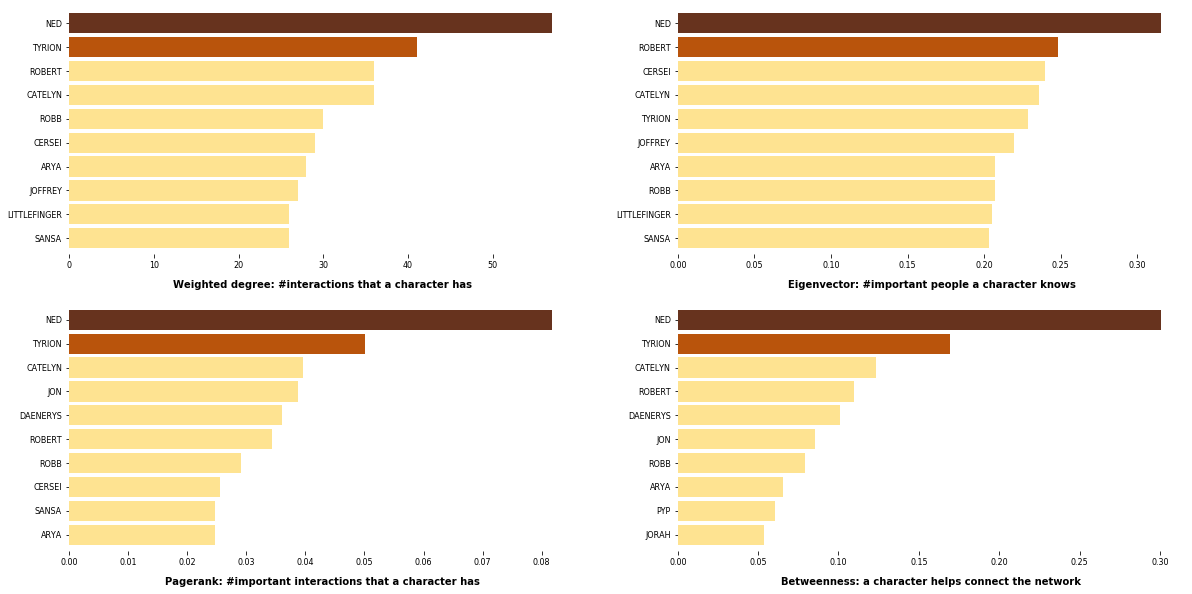

In [6]:
draw_centrality(firstSeasonGraph)

From the analysis of the centrality measures we can say that <b>Ned Stark</b> is undoubtedly the most important character of the first season. <b>Tyrion</b> is the second most important character in the series although he is only in fifth place for eigenvector centrality due to the fact that he is not involved in the plots of King's Landing. Third place belongs to <b>Catelyin</b>, a strong woman devoted to her family.

<h1>Fifth season</h1>

In [7]:
fifthSeasonGraph = load_file('data/got/got-s5-edges.csv')
print(nx.info(fifthSeasonGraph))

Name: 
Type: Graph
Number of nodes: 119
Number of edges: 396
Average degree:   6.6555


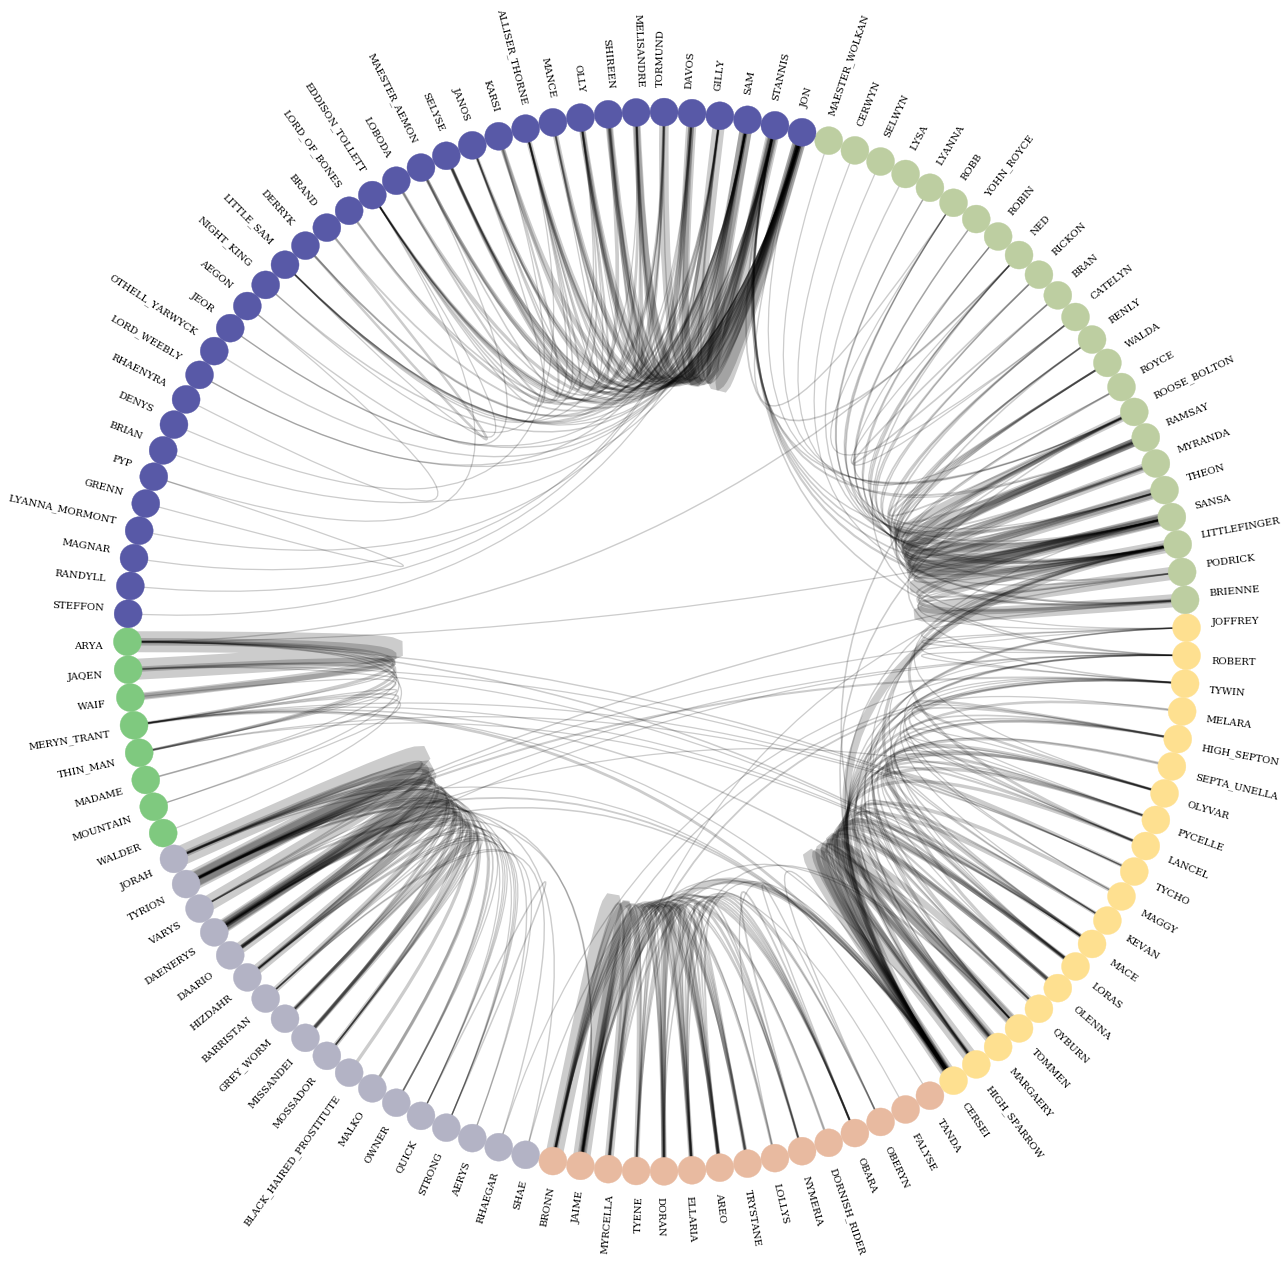

In [8]:
draw_circos(fifthSeasonGraph)

The network has six communities:
<ul>
<li><b>Night’s Watch:</b> Jon, Stannis, Sam</li>
<li><b>Winterfell:</b> Littlefinger, Sansa</li>
<li><b>King’s Landing:</b> Cersei, Pycelle, Qyburn</li>
<li><b>Dorne:</b> Jaime, Bronn</li>
<li><b>Essos:</b> Tyrion, Varys, Daenerys</li>
<li><b>Braavos:</b> Arya</li>
</ul>

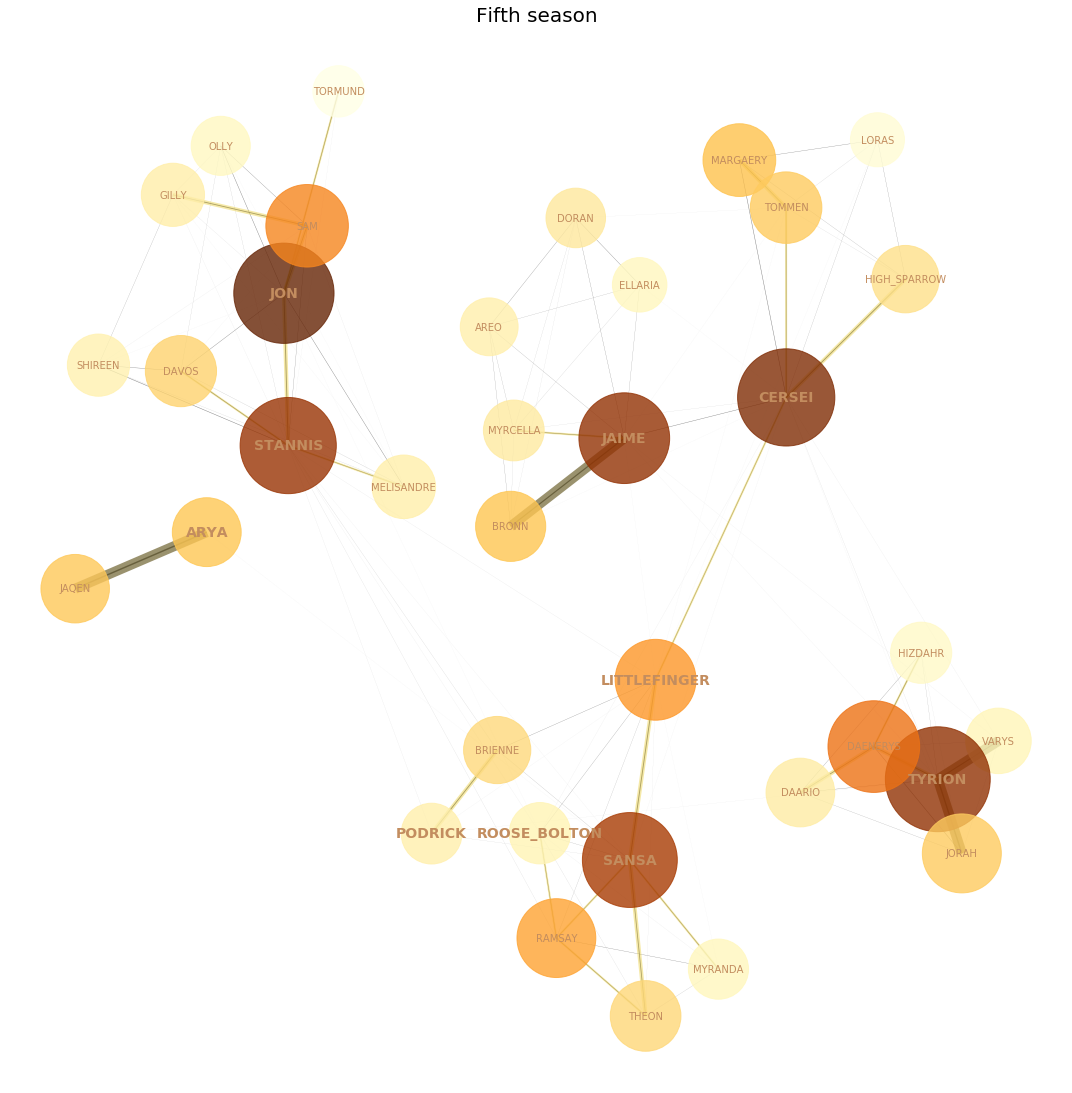

In [13]:
sum_weighted_degree = sum([fifthSeasonGraph.degree(v,weight='weight') for v in fifthSeasonGraph])
weighted_degree = { v: (fifthSeasonGraph.degree(v,weight='weight')/sum_weighted_degree) for v in fifthSeasonGraph}
sorted_degree = pd.Series(weighted_degree).sort_values(ascending=False)
fifthSeasonGraphTemp = nx.subgraph(fifthSeasonGraph,sorted_degree[sorted_degree>0.01].index)
draw_standard_graph(fifthSeasonGraphTemp, 'Fifth season', seed=8, k=2)

Important 4-cliques are:
    <ul>
    <li><b>Jon, Stannis, Melisandre, Davos:</b> this 4-clique captures the seige planning for Winterfell</li>
    <li><b>Jorah, Daario, Tyrion, Daenerys:</b> this 4-clique tells us about the events in Essos</li>
    <li><b>Cersei, Tommen, High Sparrow, Margaery:</b> this 4-clique tells the clash between the High Sparrow and the families of the Lannyster and Tyrell</li>
    <li><b>Sansa, Ramsey, Theon, Myranda:</b> this 4-clique tells us about the terrible situation in which Sansa found herself</li>
    </ul>    
Important triads are:
    <ul>
    <li><b>Jon, Sam, Olly:</b> this triad explores Jon’s new role as Lord Commander of Night’s Watch</li>
    <li><b>Stannis, Davos, Shireen:</b> this triad brings the father-daughter-mentor dynamic on stage</li>
    <li><b>Jaime, Bronn, Myrcella:</b> this triad captures the mission to return Myrcella to Cersei community</li>
    <li><b>Little Finger, Sansa, Ramsey:</b> this triad tells us about the illusion of a happy turn for Sansa</li>
    </ul>

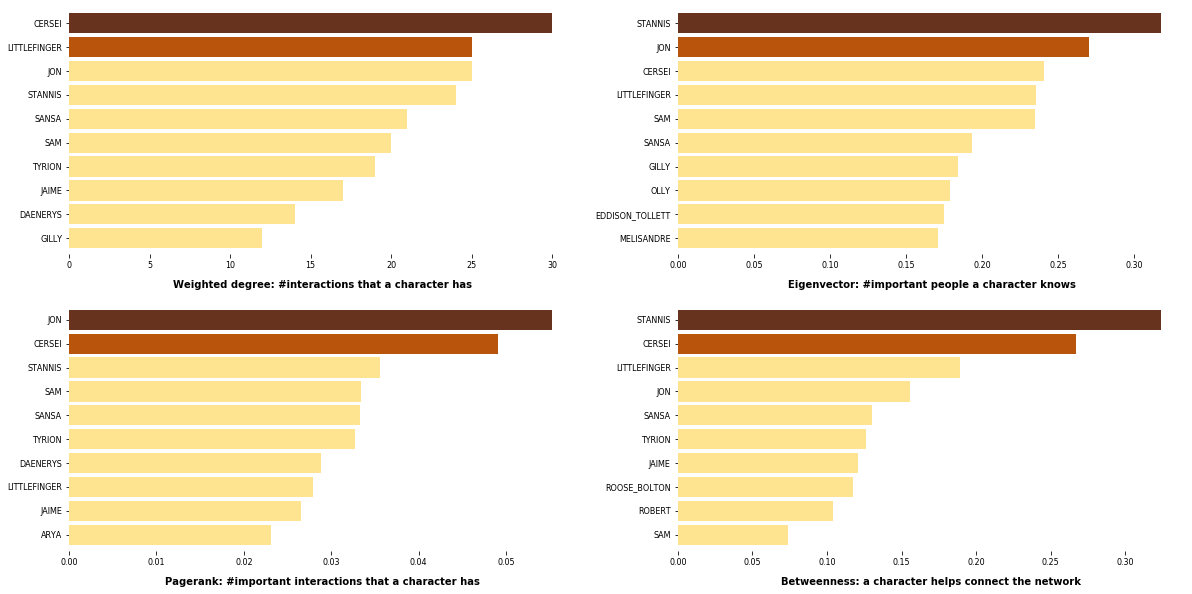

In [100]:
draw_centrality(fifthSeasonGraph)

 The various centralities are more heterogeneous than those of the first season.<br>We can say that the most important character is <b>Cersey</b> in the clash with the High Sparrow followed by <b>Stannis</b> with his plans to conquer Winterfell.<br>
The third place is up to <b>Jon</b> who, becoming the king of the Night’s Watch. becomes more and more a central character.<br>
<b>Littlefinger</b> turns out to be a very important character and his plans are proving successful.

<h1>Last season</h1>

In [24]:
lastSeasonGraph = load_file('data/got/got-s8-edges.csv')
print(nx.info(lastSeasonGraph))

Name: 
Type: Graph
Number of nodes: 74
Number of edges: 553
Average degree:  14.9459


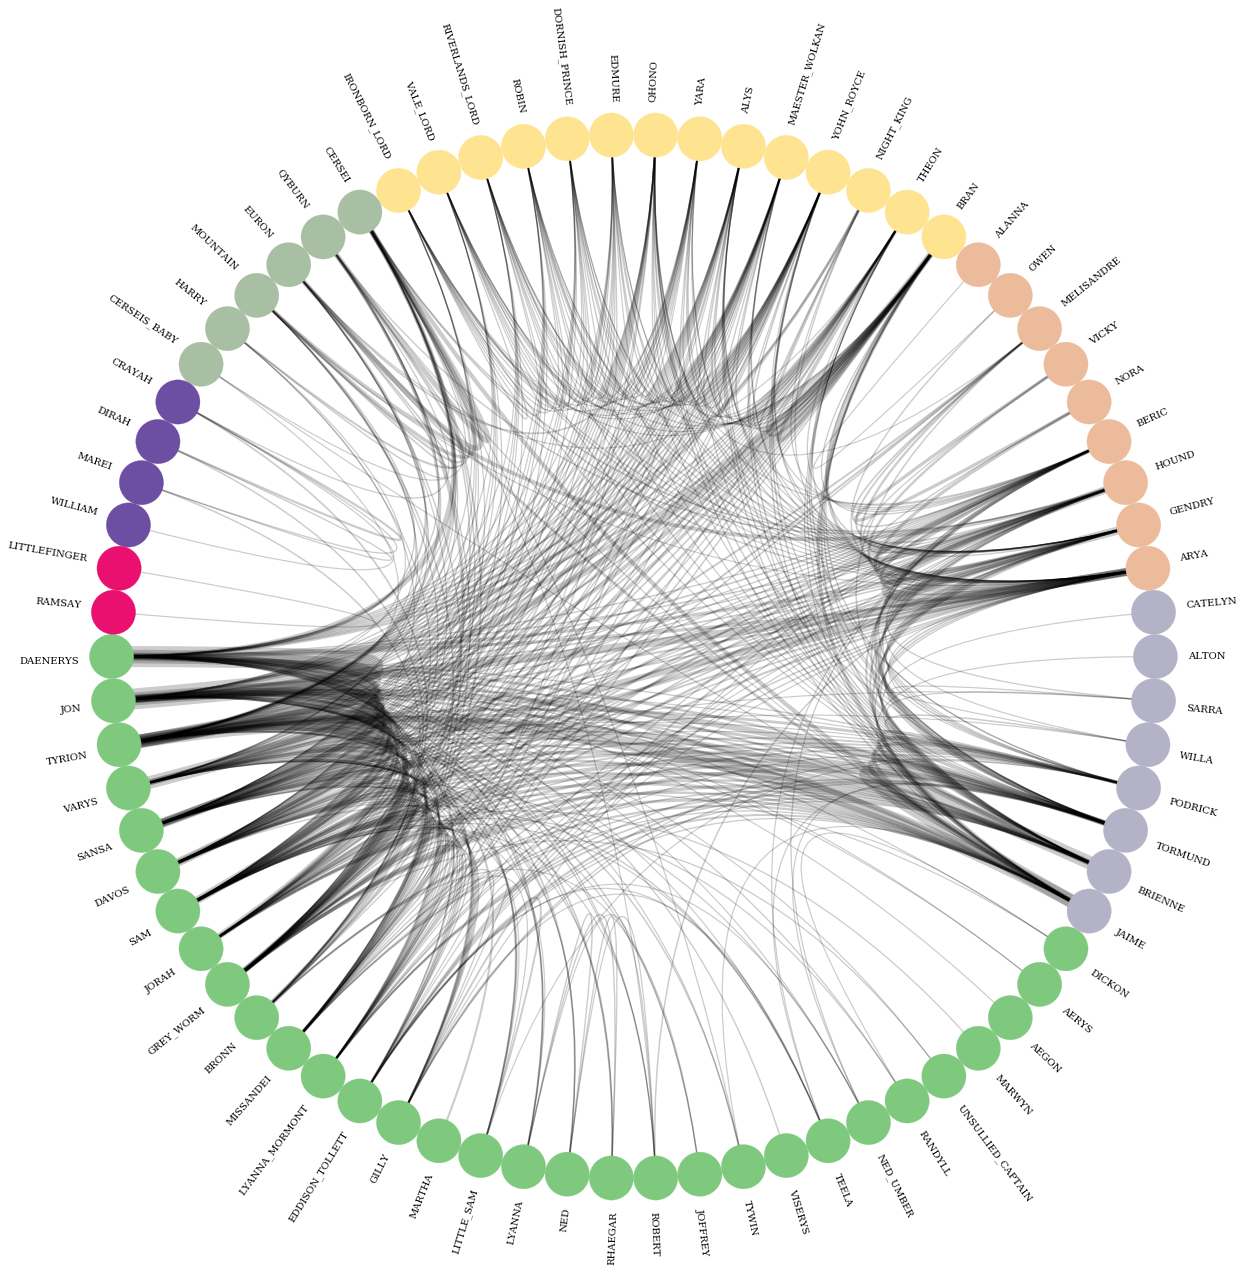

In [25]:
draw_circos(lastSeasonGraph)

The network for the final season is small, and <b>very dense</b>.
The problem with analyzing communities this season is that there are two long and distinct fighting sequences ("The Long Night" and "The Bells").<br>
However, it is possible to identify the <b>Stark/Targaryen</b> community that fought the two battles together and the isolated community of <b>Cersei</b>.

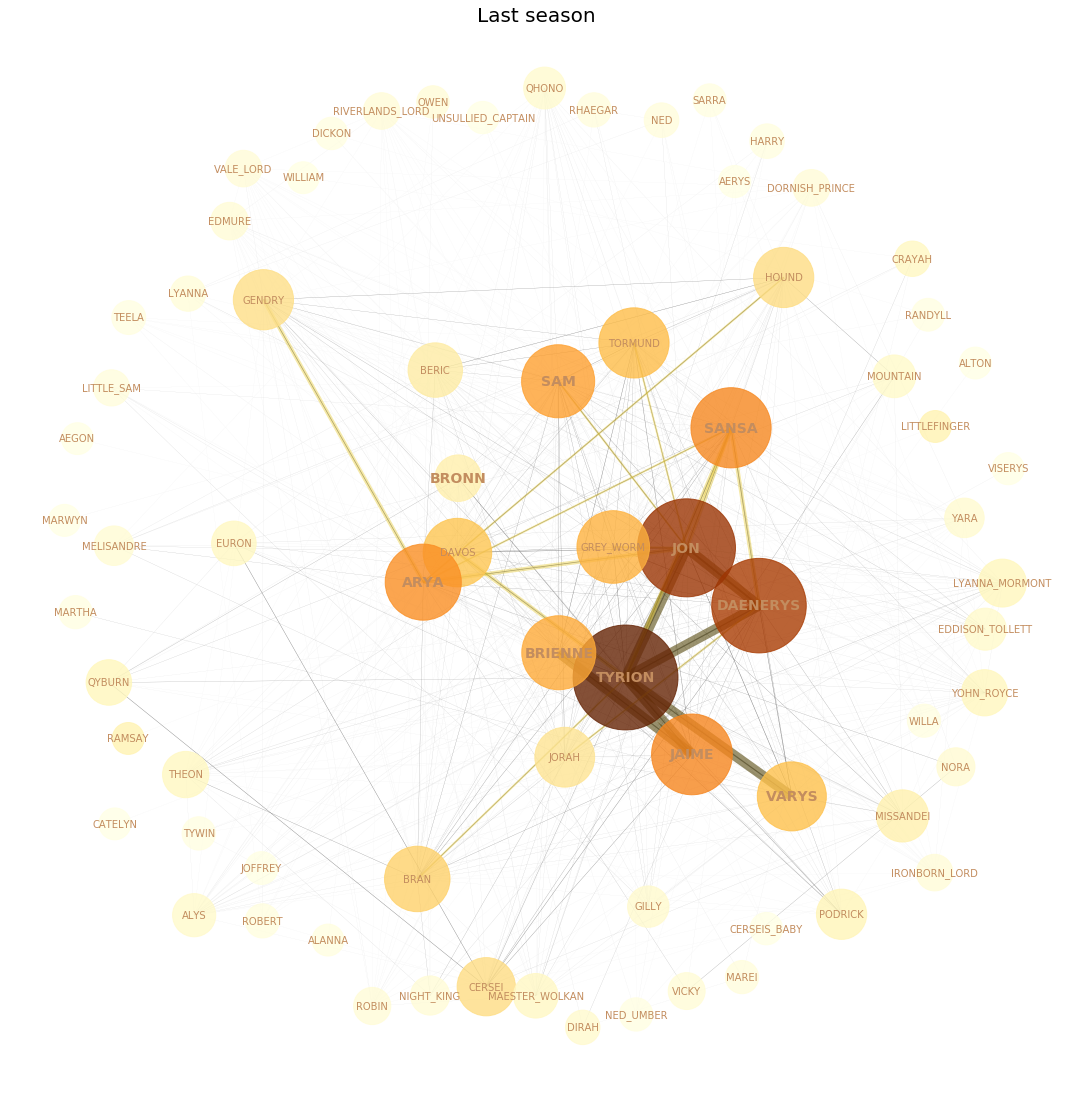

In [26]:
draw_standard_graph(lastSeasonGraph, 'Last season')

<b>Tyrion, Jon, Daenerys</b> is the most important and most visible triad. In addition, this triad contains the most important characters of this season.<br>
Other noteworthy triads are:
<ul>
<li><b>Daenerys, Tyrion, Varys</b></li>
<li><b>Cersei, Euron, Qyburn</b></li>
<li><b>Arya, Hound, Gendry</b></li>
</ul>

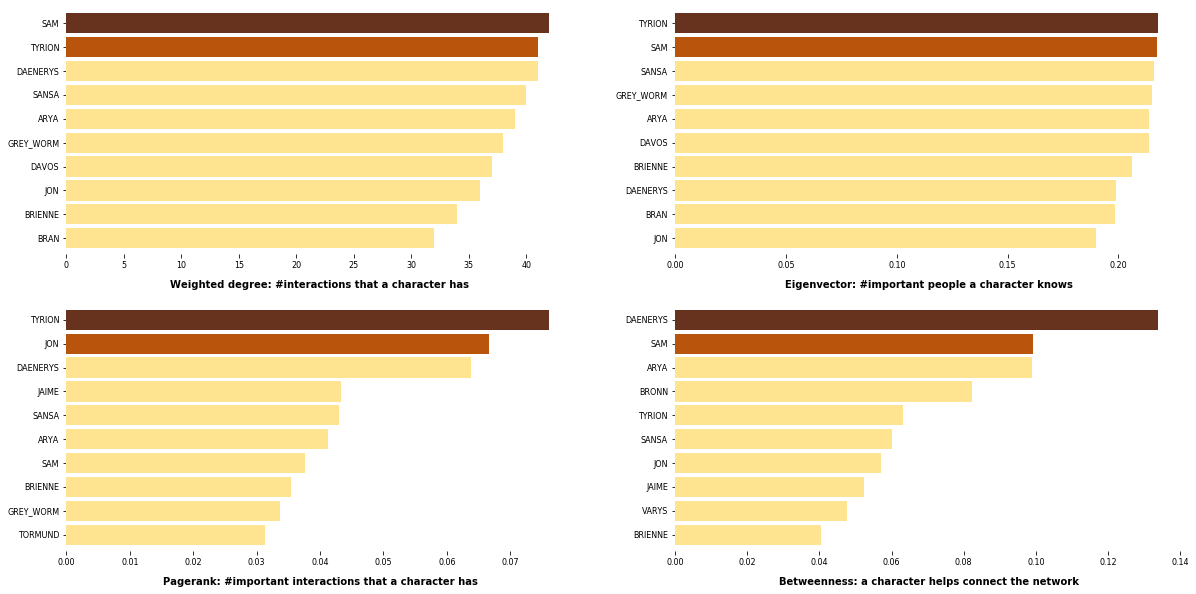

In [27]:
draw_centrality(lastSeasonGraph)

We finish this analysis by finding out who dominated the end of the series.<br>
The first place as the most important character of the season belongs to <b>Tyrion</b> who dominates two categories and falls on the podium in the other two.
<b>Daenerys</b>, in addition to having good scores in weighted degree and pagerank centrality, has the maximum betweenness centrality, so it is the character who connects the various plot lines.<br>
In third place we find <b>Sam and Jon</b>: Jon scored well in all centralities while Sam got the second place in eigenvector centrality and in betweenness centrality thanks to the precious help he gave to his friends, revealing himself as one of the most important characters of the series.